In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

In [27]:
#df = pd.read_excel("GlobalTemperatures_00-15.xlsx", index_col = 'Xm')

In [2]:
%run f2forecast.py

In [3]:
%matplotlib inline

In [52]:
def to_datetime(df):
    date = datetime.strptime(df, '%Y-%m-%d')
    return date.strftime("%d.%m.%Y")

In [54]:
df = pd.read_csv('GlobalTemperatures_96-15.csv', sep=',')
df = df.rename(columns={'dt': 'Date', 'LandAverageTemperature': 'Temp'})
#df.index = pd.to_datetime(df)
#df['dt'] = df['dt'].apply(lambda x: to_datetime(x))

In [57]:
df['Date']= pd.to_datetime(df['Date'])

In [55]:
df.dtypes

Date     object
Temp    float64
dtype: object

In [9]:
df = df.set_index('Date')
df.head(3)

,Temp
Date,
1996-01-01,2.862
1996-02-01,4.012
1996-03-01,5.524


In [10]:
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name='Date', length=240, freq=None)

In [11]:
df.head()

,Temp
Date,
1996-01-01,2.862
1996-02-01,4.012
1996-03-01,5.524
1996-04-01,8.679
1996-05-01,11.588


In [12]:
df.shape

(240, 1)

In [13]:
df = validate_series(df)

In [14]:
print(df)

              Temp
Date              
1996-01-01   2.862
1996-02-01   4.012
1996-03-01   5.524
1996-04-01   8.679
1996-05-01  11.588
...            ...
2015-08-01  14.755
2015-09-01  12.999
2015-10-01  10.801
2015-11-01   7.433
2015-12-01   5.518

[240 rows x 1 columns]


Text(0, 0.5, 'Temperature')

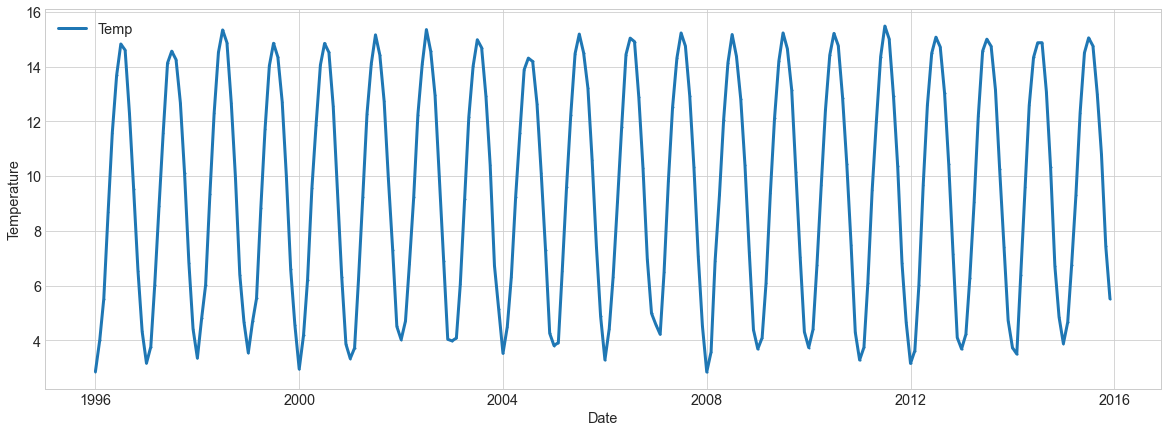

In [15]:
plot(df, ts_linewidth = 3, figsize=(20,7))
plt.legend(fontsize='x-large')

#plt.plot(df['dt'], df['LandAverageTemperature'], label = 'LandAverageTemperature')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Date', fontsize='x-large')
plt.ylabel('Temperature', fontsize='x-large')
#plt.legend()
#plt.show()

<h1>Выявление и корректировка аномалий</h1>

Будем убирать еденичные не системные позиции которые выбиваються из общей тендентции


In [16]:
#Посмотрим на характеристики ряда с помощью функции describe
df.describe()

,Temp
count,240.000000
mean,9.486137
std,4.142184
min,2.844000
25%,5.522500
50%,9.673500
75%,13.333000
max,15.482000


[None]

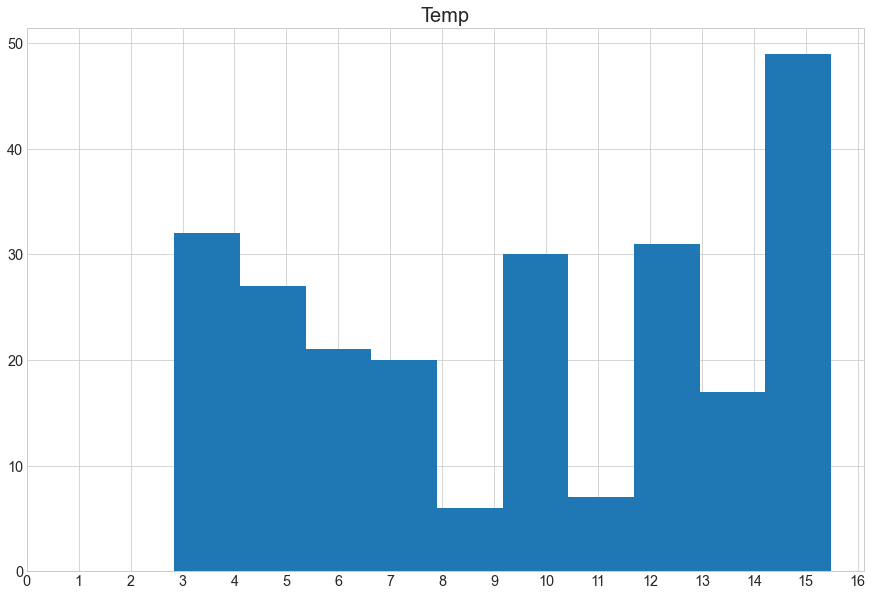

In [17]:
#построим гестраграмму нашего ряда
#Частота встречаемости иех или иных значений (значения около 15 встречались чаще)
fig = df.hist(figsize=(15,10), label = 'x-large')
plt.xticks(range(17), fontsize='x-large')
plt.yticks(fontsize='x-large')
[x.title.set_size(20) for x in fig.ravel()]

Count – количество значений в датасете.

Mean – среднее значение по ряду.

Std – стандартная ошибка.

Min – минимальное значение.

25%, 50%, 75% - значения границ квартилей. 50% - это не что иное, как медиана. В нормально распределенных не смещенных данных, как правило, медиана и среднее значение близки друг к другу.

Max – максимальное значение.

Используя эти данные, посмотрим на данные и возможные выбросы.

Text(0, 0.5, 'Temperature')

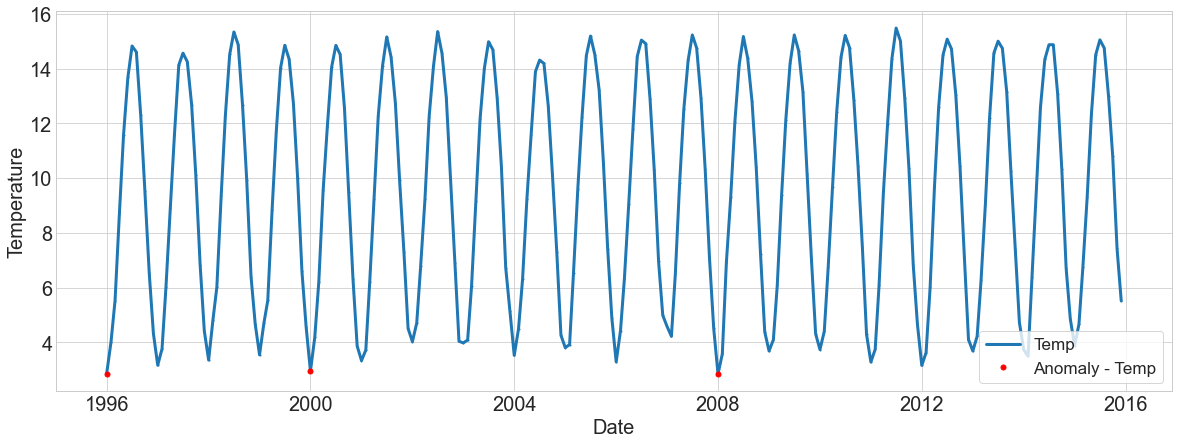

In [18]:
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high = 15.5, low = 3)
anomalies = threshold_ad.detect(df)
plot(df, anomaly = anomalies, ts_linewidth = 3, anomaly_markersize = 5, anomaly_color = 'red', anomaly_tag = 'marker', figsize = (20,7)  )

plt.legend(fontsize='17',loc="lower right", frameon = True)


plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Temperature', fontsize='20')

In [19]:
#В какие периоды были отмечены аномалии 
anomalies[anomalies.Temp]

,Temp
Date,
1996-01-01,True
2000-01-01,True
2008-01-01,True


Воспользуемся более сложным детектором аномалий. Следующий детектор основан на оценке отклонения образца ряда от соседей. Метод оценивает, насколько изолирован объект относительно окружения. Точнее, локальность определяется k-ближайшими соседями, расстояние которых используется для оценки локальной плотности. Сравнивая локальную плотность образца с локальными плотностями его соседей, можно идентифицировать образцы, которые имеют существенно меньшую плотность, чем их соседи. Они считаются выбросами

In [20]:
from sklearn.neighbors import LocalOutlierFactor

Text(0, 0.5, 'Temperature')

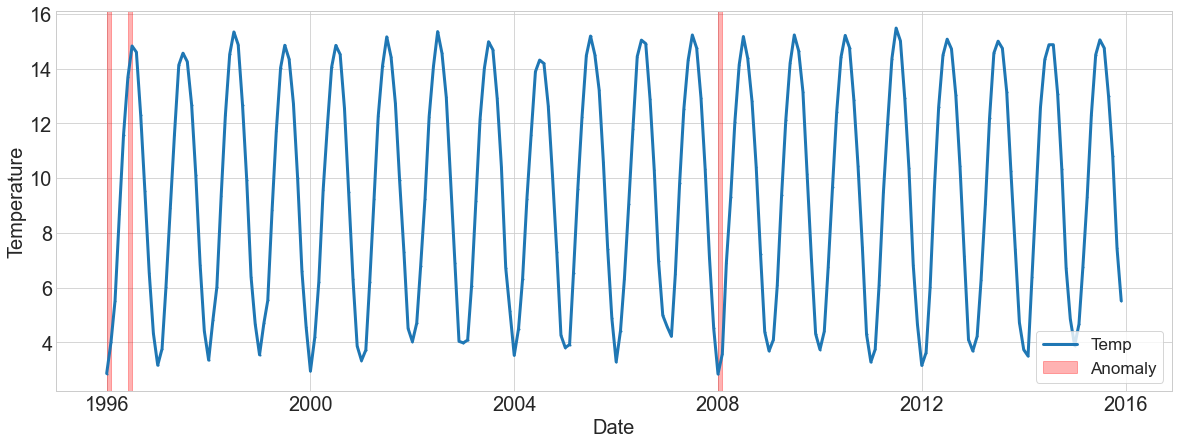

In [21]:

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all', figsize = (20,7));
plt.legend(fontsize='17',loc="lower right", frameon = True)


plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Temperature', fontsize='20')

Аномалии подсвечены красным. Изменяя параметр contamination, можно менять чувствительность модели. Чем больше значение, тем более подозрительно она будет относиться к аномалиям. Посмотреть даты, которые модель подозревает на наличие аномалий, можно командой:

In [22]:
anomalies[anomalies]

Date
1996-01-01    True
1996-06-01    True
2008-01-01    True
dtype: bool

Еще один тест на аномальность – это оценка наличия сезонной компоненты. Построим совмещенные графики по годам. Цифра 12 в параметрах функции означает, сколько периодов длится сезон (если по месяцам – 12, если по кварталам – 4).

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

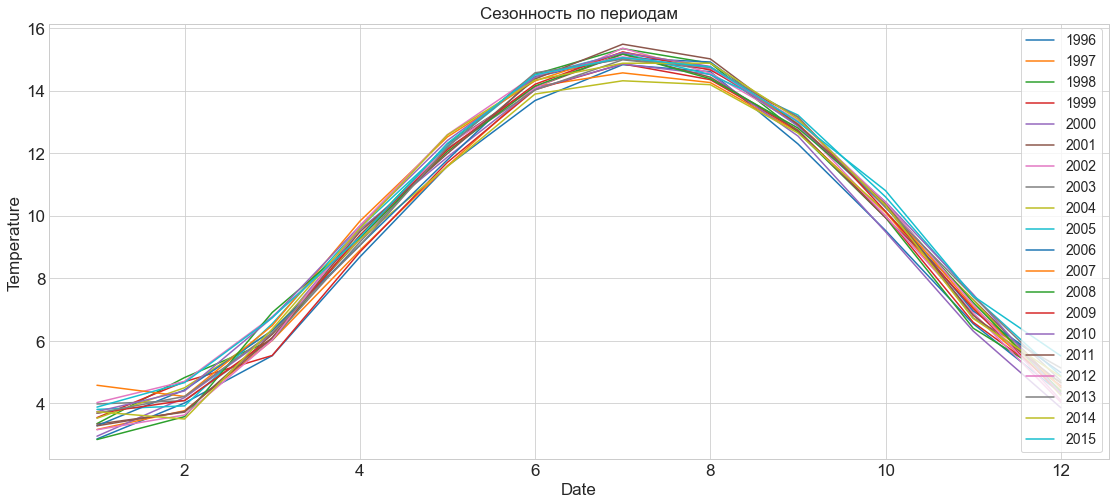

In [24]:
sesonal(df,12)


<h1>Сколько дней тренировочные, остальные для прогнозирования</h1>

In [44]:
num_shape = 192

train = df.iloc[:num_shape, 0:2].values
test = df.iloc[num_shape:, 0:2].values

нормализовать данные для лучшего нахождения локального и глобального минимума

In [45]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [46]:
X_train = []

#Price on next day
y_train = []

window = 10

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)


In [47]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

<h1>Обучение модели</h1>

In [74]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_split=0.1);

Epoch 1/100
11/11 [==============================] - 18s 286ms/step - loss: 0.0342 - val_loss: 0.0057
Epoch 2/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0145 - val_loss: 0.0167
Epoch 3/100
11/11 [==============================] - 1s 51ms/step - loss: 0.0157 - val_loss: 0.0021
Epoch 4/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0170 - val_loss: 0.0044
Epoch 5/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0129 - val_loss: 0.0091
Epoch 6/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0127 - val_loss: 0.0042
Epoch 7/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0129 - val_loss: 0.0187
Epoch 8/100
11/11 [==============================] - 1s 55ms/step - loss: 0.0131 - val_loss: 0.0025
Epoch 9/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0094 - val_loss: 0.0021
Epoch 10/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0117 - val_loss: 0.00

Epoch 82/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 83/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 84/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 85/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 86/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 87/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 88/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 89/100
11/11 [==============================] - 0s 33ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 90/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0069 - val_loss: 0.0028
Epoch 91/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0064 - val_los

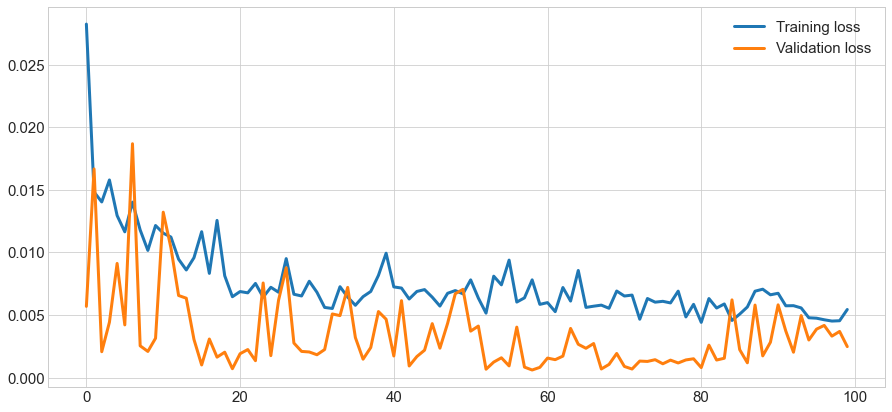

In [75]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='Training loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation loss', linewidth=3)
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.legend(fontsize='15')


In [76]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [77]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

Среднеквадратическая ошибка MSE<br>
Средняя абсолютная ошибка MAE<br>
Среднеквадратическое отклонение RMSE

In [78]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 0.6270464869050126
MAE: 0.651479179461797
RMSE: 0.7918626692204985


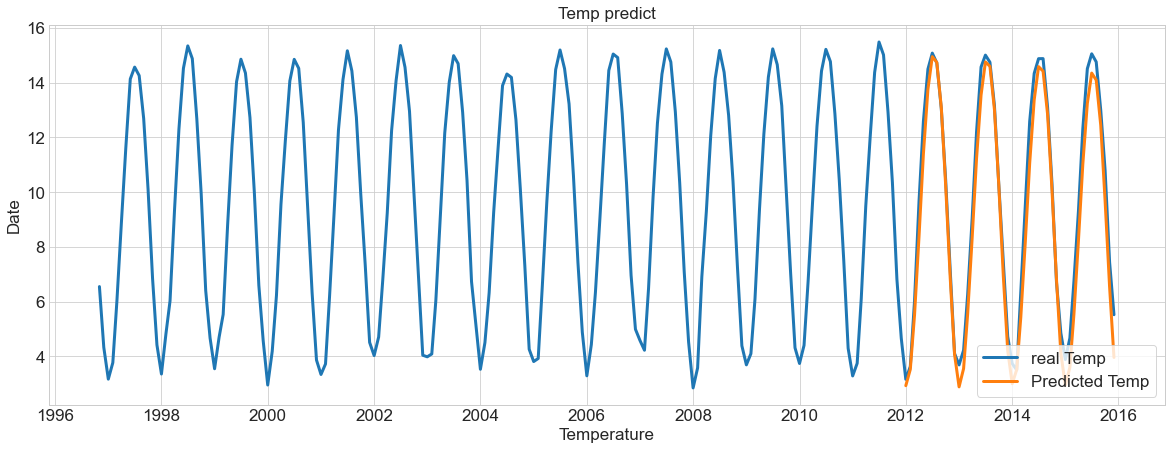

In [79]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[10:], df_volume[10:], label = 'real Temp', linewidth=3)
plt.plot(df['Date'][-predict.shape[0]:].values, predict, label = 'Predicted Temp', linewidth=3)
plt.xticks(fontsize='17')
plt.yticks(fontsize='17')
plt.title('Temp predict', fontsize='17')
plt.xlabel('Temperature', fontsize='17')
plt.ylabel('Date', fontsize='17')
plt.legend(fontsize='17',loc="lower right", frameon = True)